# VQO of the Magic Squares Game

In this notebook, we demonstrate the use of variational quantum optimization (VQO) to find optimal quantum strategies for the magic square game.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


## Implementing the Optimal Quantum Strategy

In this section, we show how PennyLane can be used to simulate the optimal quantum strategy for the magic squares game.
The optimal quantum strategy is implemented as described in Appendix C of https://arxiv.org/pdf/1909.02479.pdf.

### Ideal State Preparation

For the ideal quantum strategy, the state is initialized as 

$$
|\psi_{A_1A_2B_1B_2}\rangle = \frac{1}{2}\left(|00\rangle_{A_1A_2}|11\rangle_{B_1B_2} + |11\rangle_{A_1A_2}|00\rangle_{B_1B_2}- |01\rangle_{A_1A_2}|10\rangle_{B_1B_2} - |10\rangle_{A_1A_2}|01\rangle_{B_1B_2} \right)
$$

In [2]:
dev = qml.device("default.qubit", wires=range(4))

def ideal_init_state():
    for i in range(4):
        qml.PauliX(wires=[i])

    for i in range(2):
        qml.Hadamard(wires=[i])
        qml.CNOT(wires=[i,i+2])
    
@qml.qnode(dev)
def ideal_init_state_qnode_test():
    ideal_init_state()
    
    return qml.state()

assert np.allclose(ideal_init_state_qnode_test(), np.array([0,0,0,1,0,0,-1,0,0,-1,0,0,1,0,0,0])/2)

print(ideal_init_state_qnode_test.draw())

 0: ──X──H──────╭C──╭┤ State 
 1: ──X──H──╭C──│───├┤ State 
 2: ──X─────│───╰X──├┤ State 
 3: ──X─────╰X──────╰┤ State 



### Ideal Measurments

The ideal measurements are encoded as unitaries applied to the initialized states.
These unitaries perform a rotation on the computational basis to effectively create a new measurement basis.

In [3]:
# TODO: reconstruct ideal unitaries as expressed in appendix C of https://arxiv.org/pdf/1909.02479.pdf.

### Verifying Unitaries

To construct a unitary matrix from a sequence of gates, we need to perform unitary tomography on the quantum circuit.
This is easily done in PennyLane using the `qml.state()` return value to get the state vector from the quantum simulator.

In [3]:
def unitary_tomography(device, quantum_fn, *args, verbose=False, **kwargs):
        
    @qml.qnode(device)
    def test_unitary_circ(val):
        bin_vals = np.binary_repr(val,len(test_dev.wires))

        for (i, bin_val) in enumerate(bin_vals):
            if int(bin_val) == 1:
                qml.PauliX(wires=test_dev.wires[i])

        quantum_fn(*args, **kwargs)

        return qml.state()
    
    dim = 2**len(device.wires)
    evaluated_unitary = np.zeros((dim,dim), dtype=complex)
    for val in range(dim):
        state = test_unitary_circ(val)
        
        if verbose:
            print("initialized basis state :", val)
            print(test_unitary_circ.draw())

            print("state :", state)

        evaluated_unitary[0:,val] = state

    return evaluated_unitary

## Optimizing the Optimal Quantum Strategy

We need a cost function to minimize with respect to the magic squares game.
This can simply be $-P_{win}$ which is the negative winning probability for quantum magic squares strategy.
The winning probability is computed as $P_{win} = \sum_{x,y=0}^2 P(win|x,y)$ where $P(win|x,y)$ is the probability that the $x^{th}$ bit of Alice equals the $y^{th}$ bit of Bob.
The first two bits of Alice and Bob's respective bitstrings are procured from the measurement outcomes on the two local qubits held by each party.
The third bit is chosen such that the parity of the whole bit string is correct (Alice has even parity and Bob has odd parity).
Given the set of probabilities $P(a_0,a_1,b_0,b_1|x,y)$ where all $a_i, b_j\in\{0,1\}$, the winning probability can easily be computed.

We now compute the winning probability for the magic square game and implement it as a cost function to be minimized.

In [15]:
# This is a factory function to create a cost function based upon the
# quantum circuit expressed in probs_qnode
def magic_squares_cost(probs_qnode):
    
    def cost(settings):
        state_settings, A_settings, B_settings = settings

        score = 0
        for x in [0,1,2]:
            for y in [0,1,2]:
                probs = probs_qnode(state_settings, A_settings[x], B_settings[y])

                for i in range(16):
                    bit_string = [int(x) for x in np.binary_repr(i,4)]

                    A_parity_bit = 0 if (bit_string[0] + bit_string[1]) % 2 == 0 else 1
                    B_parity_bit = 1 if (bit_string[2] + bit_string[3]) % 2 == 0 else 0

                    A_bits = bit_string[0:2] + [A_parity_bit]
                    B_bits = bit_string[2:] + [B_parity_bit]            

                    if A_bits[y] == B_bits[x]:
                        score += probs[i]

        return -(score/9)
    
    return cost

# creates randomized initial settings for magic squares qnodes
def rand_magic_squares_settings(num_state_settings, num_A_settings, num_B_settings):
    state_settings = 2 * np.pi * np.random.random(num_state_settings)
    A_settings = [
        2 * np.pi * np.random.random(num_A_settings) - np.pi for i in range(3)
    ]
    B_settings = [
        2 * np.pi * np.random.random(num_B_settings) - np.pi for i in range(3)
    ]
    
    return state_settings, A_settings, B_settings


### Optimizing Measurments with Ideal State Preparation

With the entangled state fixed as the ideal state, we use VQO to find the optimal quantum measurements for the magic square game.
First we define a measurement ansatz which applies an arbitrary two-qubit gate to Alice and Bob's resepective states.
Simples ansatz circuits likely exist, but the dimensions are small enough that we can optimize over the complete quantum state space.

In [16]:
@qml.qnode(dev)
def measurement_qnode(state_settings, settingsA, settingsB):
#     ideal_init_state()
    
    qml.templates.subroutines.ArbitraryUnitary(settingsA, wires=dev.wires[0:2])
    qml.templates.subroutines.ArbitraryUnitary(settingsB, wires=dev.wires[2:])
    
    return qml.probs(wires=dev.wires)

Next, we perform gradient descent to minimze the magic squares cost function.

In [18]:
%%time

opt = qml.GradientDescentOptimizer(stepsize=0.5)
num_steps = 150
sample_width = 10

measurement_cost = magic_squares_cost(measurement_qnode)

init_settings = rand_magic_squares_settings(0,15,15)
scores = []
samples = []
settings_history = []

# performing gradient descent
for i in range(num_steps):
    if i % sample_width == 0:
        score = -(measurement_cost(init_settings))
        scores.append(score)
        samples.append(i)

        print("iteration : ", i, ", score : ", score)

    # updating settings
    init_settings = opt.step(measurement_cost, init_settings)
    settings_history.append(init_settings)

opt_score = -(measurement_cost(init_settings))

scores.append(opt_score)
samples.append(num_steps - 1)

print("final score : ", opt_score)

iteration :  0 , score :  0.4433143145116584
iteration :  10 , score :  0.5606060792472338
iteration :  20 , score :  0.6962875821943145
iteration :  30 , score :  0.7793355123054937
iteration :  40 , score :  0.8291398763100155
iteration :  50 , score :  0.8571305175895726
iteration :  60 , score :  0.8710086885972914
iteration :  70 , score :  0.8781870913988722
iteration :  80 , score :  0.8821148340307173
iteration :  90 , score :  0.884376312600547
iteration :  100 , score :  0.8857457351462393
iteration :  110 , score :  0.8866155149389547
iteration :  120 , score :  0.8871920488240386
iteration :  130 , score :  0.8875886028564467
iteration :  140 , score :  0.8878701398111284
final score :  0.8880755246414924
CPU times: user 47 s, sys: 525 ms, total: 47.5 s
Wall time: 47.9 s


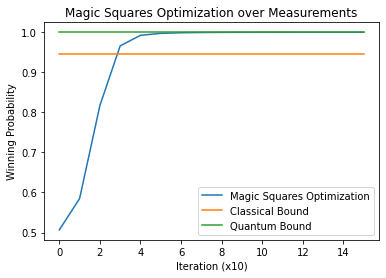

In [14]:
plt.plot(range(16), scores , label = "Magic Squares Optimization")
plt.plot(range(16), [17/18]*len(scores), label = r"Classical Bound")
plt.plot(range(16), [1]*len(scores), label = "Quantum Bound")
plt.title("Magic Squares Optimization over Measurements")
plt.xlabel("Iteration (x10)")
plt.ylabel("Winning Probability")
plt.legend()
plt.show()

In [8]:
test_dev = qml.device("default.qubit", wires=range(2))
def test_two_qubit_unitary(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings, wires=wires)

print("Alice's unitaries")
for x in [0,1,2]:
    print("x : ", x)
    mat = unitary_tomography(test_dev, test_two_qubit_unitary, init_settings[1][x],wires=test_dev.wires)
    print(mat.round(3))
    
print("Bob's unitaries")
for y in [0,1,2]:
    print("y : ", y)
    mat = unitary_tomography(test_dev, test_two_qubit_unitary, init_settings[2][x],wires=test_dev.wires)
    print(mat.round(3))


Alice's unitaries
x :  0
[[-0.54 +0.529j -0.022-0.484j -0.146-0.092j  0.343-0.217j]
 [-0.276-0.594j -0.534-0.163j -0.157+0.123j -0.104-0.456j]
 [-0.   +0.j    -0.107-0.443j  0.422-0.563j -0.534+0.108j]
 [ 0.   -0.j    -0.398-0.295j  0.406+0.52j   0.205+0.526j]]
x :  1
[[-0.368-0.003j  0.067+0.445j -0.209-0.035j -0.149+0.772j]
 [-0.   -0.j     0.43 +0.115j  0.573-0.688j -0.028+0.015j]
 [-0.896-0.248j  0.02 -0.177j  0.076+0.035j  0.136-0.28j ]
 [-0.   +0.j     0.299-0.692j  0.242+0.297j -0.375+0.38j ]]
x :  2
[[-0.8  +0.092j  0.287+0.397j -0.299+0.132j -0.063-0.031j]
 [-0.   -0.j     0.476-0.026j  0.02 -0.744j  0.141+0.446j]
 [ 0.   -0.j    -0.002-0.301j -0.306-0.221j -0.871-0.094j]
 [ 0.533+0.26j   0.039+0.664j -0.439-0.068j -0.05 -0.081j]]
Bob's unitaries
y :  0
[[-0.   -0.j     0.023+0.177j -0.187-0.951j -0.114+0.121j]
 [ 0.898-0.351j  0.017+0.04j   0.046+0.018j  0.096+0.237j]
 [-0.099-0.245j -0.146+0.064j -0.062+0.17j  -0.861+0.362j]
 [ 0.   -0.j    -0.795+0.556j -0.135+0.08j   0.166

### Optimizing Entangled States for Optimal Quantum Strategy

With the measurements fixed as the ideal measurements, we demonstrate the use of VQO to find a four-qubit state that performs the optimal quantum strategy.

In [10]:
# TODO: 

### Finding Optimal Quantum States and Measurements for the Magic Square Game

In this section, we use VQO to find a quantum state and measurements that win the magic squares game with perfect probability.

In [11]:
@qml.qnode(dev)
def general_magic_squares_qnode(state_settings, settingsA, settingsB):
    qml.templates.subroutines.ArbitraryUnitary(state_settings, wires=dev.wires)
    
    qml.templates.subroutines.ArbitraryUnitary(settingsA, wires=dev.wires[0:2])
    qml.templates.subroutines.ArbitraryUnitary(settingsB, wires=dev.wires[2:])
    
    return qml.probs(wires=dev.wires)

Now we optimize the winning probability over the complete state and measurement spaces.

In [12]:
%%time

opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_steps = 150
sample_width = 10
gen_cost = magic_squares_cost(general_magic_squares_qnode)

init_settings = rand_magic_squares_settings(255,15,15)
scores = []
samples = []
settings_history = []

# performing gradient descent
for i in range(num_steps):
    if i % sample_width == 0:
        score = -(gen_cost(init_settings))
        scores.append(score)
        samples.append(i)

        print("iteration : ", i, ", score : ", score)

    # updating the initialized settings
    init_settings = opt.step(gen_cost, init_settings)
    settings_history.append(init_settings)

opt_score = -(gen_cost(init_settings))

scores.append(opt_score)
samples.append(num_steps - 1)

print("final score : ", opt_score)

iteration :  0 , score :  0.5348510860020586
iteration :  10 , score :  0.7175614746375654
iteration :  20 , score :  0.8396404346863825
iteration :  30 , score :  0.9049605298293257
iteration :  40 , score :  0.9414380837590559
iteration :  50 , score :  0.9631638742999231
iteration :  60 , score :  0.9763905259431466
iteration :  70 , score :  0.9845624976742013
iteration :  80 , score :  0.9896950273248317
iteration :  90 , score :  0.9929774591220046
iteration :  100 , score :  0.9951160220693309
iteration :  110 , score :  0.9965349347766802
iteration :  120 , score :  0.9974930937977378
iteration :  130 , score :  0.9981512928114051
iteration :  140 , score :  0.9986111195200544
final score :  0.9989377757032278
CPU times: user 8min 14s, sys: 3.79 s, total: 8min 18s
Wall time: 8min 21s


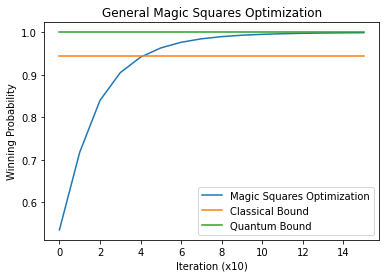

In [14]:
plt.plot(range(16), scores , label = "Magic Squares Optimization")
plt.plot(range(16), [17/18]*len(scores), label = r"Classical Bound")
plt.plot(range(16), [1]*len(scores), label = "Quantum Bound")
plt.title("General Magic Squares Optimization")
plt.xlabel("Iteration (x10)")
plt.ylabel("Winning Probability")
plt.legend()
plt.show()